# ADS Midterm 2019

## Theoretic part

## Question 1 (5pts). 
Imagine traninig a model which considers multiple street segments with their characteristics and aims to predict the traffic. Some street segments from the training sample have the amount of traffic speficied for them, others do not. How would you classify this problem from Machine Learning perspective?

A. Supervised leanring;

B. Unsupervised learning;

C. Semi-supervised learning;

D. Reinforcement learning.

Explain you choice:

In [1]:
# C bc it partially has the output  and C as it does nat have all the outputs 

## Question 2 (5pts). 
Regression $y\sim a_1 x_1 + a_2 x_2 +a_3 x_3$ have p-value of $0.03$ for $x_1$, $0.3$ for $x_2$ and $0.15$ for $x_3$. Does in mean that (select all that apply):

A. Impact of $x_3$ is twice stronger than impact of $x_2$.

B. Regressors $x_2$ and $x_3$ are irrelevant.

C. One could reject the null-hypothesis $a_j=0$ only for $j=1$ but not for $j=2$ and $j=3$ at 95% singificance level.

D. The estimated value of $a_1$ is statistically significant.

E. 95%-confidence indervals for $a_2$ and $a_3$ should contain zero. 

In [2]:
#  D. since the beta coefficient is the degree of change in the outcome variable for every 1-unit of change in the predictor variable.

### Question 3 (10pts). 
You trained the regression model with 100 regressors and 1000 observations in the training and another 1000 in the validation sample. You found that in-sample R2 over the training sample is 70\% and over the validation sample only - 30\%. 

a) Do you think there is any problem and how would you characterize it? Can adding more regressors (if you have them) help the model?

b) Which approaches you may use to solve the problem? 

c) Whould you expect the in-sample R2 to increase or decrease after that? What about the out-of-sample (validation R2)?

In [3]:
 #a tehre is a problem in splitting adding more regressors will not helpThe validation set should only be  used to evaluate a given model the numer of data should not be equal to the training
    #b- cross validation on the training data should be done    smple 
    #c- since out of sample is based on traning data similarly   it will give high correaltion 

### Question 4 (10pts). 

Below is a fraction of a multivariate regression model summary table. Suppose someone
printed it out for you but it got stained and a few numbers are unreadable (marked as AAA, BBB). 

a) Please fill them in. Explain your solution

| Variable| Coefficient | 95% Conf.Int. |
|---|---|---|
| X1 | 2 | (AAA 4) |
| X2 | BBB | (4 6) |

b) Can you specify p-value for X1? 

In [4]:
#a)AAA p=1-alfa/2 =1-.05/2=0.975
#BBB is the slope coefficient  between 4 and 6 

#b teh significance level is 0.05   p-values also range from 0 to 1 

In [5]:
# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Midterm: FHV Traffic Modeling for Real-Time Autonomous Vehicle Solutions in LGA

Transportation network models are essential to transportation operations and planning. A simple yet well-designed linear model can provide us insights on the traffic demand. We are going to model the outgoing traffic around La Guardia airport, one of the busiest transportation hubs in NYC. 
In this test, you'll be asked to:
* Find possible correlations from observations
* Incoperate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

We will be importing the dataset `LGA60.csv` providing FHV ridership and arrivals at the airport aggregated on the hourly basis:
* `fhv`: Number of FHV (For Hire Vehicle) departing from LGA. This is our target variable.
* `arrival`: Number of incoming domestic flights arriving LGA, which is assumed to provide a basis for future FHV demand

In [6]:
# import and curate the dataset
dataset = pd.read_csv("LGA60.csv")

FileNotFoundError: [Errno 2] File b'LGA60.csv' does not exist: b'LGA60.csv'

In [ ]:
dataset.head()

In [ ]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
dataset.date = pd.to_datetime(dataset.date, format='%y/%m/%d %H:%M')

In [ ]:
#get day from beginning of the year, hour and day of the week from datetime
dataset['hour']=pd.DatetimeIndex(dataset.date).hour

In [ ]:
#get day of the week; monday - 0, sunday - 6
dataset['dow']=pd.DatetimeIndex(dataset.date).weekday

In [ ]:
#get day from beginning of the year
dataset['day']=((dataset.date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

In [ ]:
#add time-lagged arrivals (1,2,3,4,5,6,...9 hours before)
maxlag = 9
lagdata=pd.DataFrame([])
for lag in range(1,maxlag+1):
        varname = 'lag' + str(lag)
        lagdata[varname] = dataset['arrival'].iloc[maxlag-lag:len(dataset)-lag].reset_index(drop = True)
datasetL = pd.concat([dataset.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)

In [10]:
datasetL.head()

,date,arrival,fhv,hour,dow,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
0,2018-01-01 09:00:00,15,228,9,0,0,14,5,0,0,0,0,1,0,3
1,2018-01-01 10:00:00,30,253,10,0,0,15,14,5,0,0,0,0,1,0
2,2018-01-01 11:00:00,18,405,11,0,0,30,15,14,5,0,0,0,0,1
3,2018-01-01 12:00:00,14,273,12,0,0,18,30,15,14,5,0,0,0,0
4,2018-01-01 13:00:00,20,254,13,0,0,14,18,30,15,14,5,0,0,0


In [11]:
#split the data into training, validation and testaa
train=datasetL.loc[datasetL.day<90,:]
valid=datasetL.loc[(datasetL.day>=90)&(datasetL.day<270),:]
test=datasetL.loc[datasetL.day>=270,:]

## Task 1. Data Exploration
### Q1 (5pts). Print some dataset characteristics: number of records, total number of FHV trips, total number of arriving flights

In [13]:
# Solution
number_Of_Records = datasetL.shape[0]
NOf_FHV = datasetL.fhv.sum()
NOf_Arrival_Flights = datasetL.arrival.sum()
print('Number of Records {0}'.format(number_Of_Records))
print('Total Number of FHV Trips {0}'.format(NOf_FHV))
print('Total Number of Arrival Flights {0}'.format(NOf_Arrival_Flights))

Number of Records 8751
Total Number of FHV Trips 3094625
Total Number of Arrival Flights 163690


### Q2 (10pts). Visualize the timeline of FHV rides and arriving flights over the first month (January, 2018)

In [14]:
#datasetL=pd.to_numeric(datasetL,errors='coerce')
 #datasetL['date']=datasetL.loc date>= (2018,1,1)
    
datasetLjan=datasetL[datasetL.day<32]
datasetLjan.tail()

,date,arrival,fhv,hour,dow,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
754,2018-02-01 19:00:00,34,736,19,3,31,34,28,39,35,28,32,30,25,41
755,2018-02-01 20:00:00,32,624,20,3,31,34,34,28,39,35,28,32,30,25
756,2018-02-01 21:00:00,25,734,21,3,31,32,34,34,28,39,35,28,32,30
757,2018-02-01 22:00:00,23,606,22,3,31,25,32,34,34,28,39,35,28,32
758,2018-02-01 23:00:00,12,500,23,3,31,23,25,32,34,34,28,39,35,28


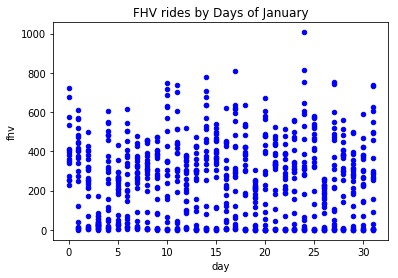

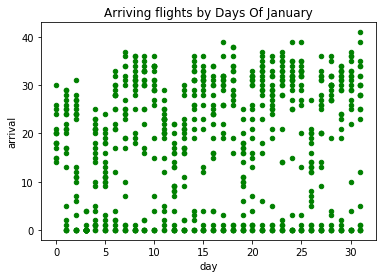

In [17]:
datasetLjan.plot(x='day',y='fhv',color='b',kind='scatter',title='FHV rides by Days of January')
datasetLjan.plot(x='day',y='arrival',color='g',kind='scatter',title='Arriving flights by Days Of January')

### Q3 (5pts). Report correlation between FHV rides and arriving flights

In [23]:
np.corrcoef(datasetL.fhv,datasetL.arrival)


array([[1.        , 0.75299452],
       [0.75299452, 1.        ]])

In [24]:
#there is high  corr of 0.75 between fhv & arrival 

## Task 2: Build Linear Regression Model of FHV vs Arrival data

### Q1 (7pts). Build an OLS model with intercept (you may want to use smf.ols) over `train` using `arrival` as a sole predictor for `fhv` 
Check p-value for arrival. What does it indicate? Report the 99% confidence interval for arrival's coefficient

In [25]:

lm = smf.ols(formula='fhv~arrival', data = train).fit()
print(lm.summary())


#lm = smf.ols(formula='FHV~arrival', data = train).fit()
#print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     2784.
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:33:55   Log-Likelihood:                -13723.
No. Observations:                2151   AIC:                         2.745e+04
Df Residuals:                    2149   BIC:                         2.746e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.8056      5.127     10.299      0.0

In [26]:
lm.conf_int(alpha=0.01) # 99% CI

,0,1
Intercept,39.587185,66.024101
arrival,11.547115,12.733518


In [27]:
#p-value for arrival is smaller than 0.05 indicates strong evidence against the null hypothesis, so I  reject the null hypothesis.

### Q2 (8pts): Consider Historical Impact 
by adding time lags - add all 9 lag variables into the regression above

There is always some delay between passengers arrival and departure (e.g. passing customs, picking up luggage etc). `fhv` might be more related to historical values of flight arrivals (lag) rather than immediate `arrival`. Engineer a formulae with all the following variables and run the regression:
* arrival, lag1, ..., lagN: that happens 1hr, ..., N=9 hr ahead.
Which of the varialbes have statistically significant impact according to p-values?

In [28]:
lm = smf.ols(formula='fhv~arrival+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8+lag9', data = datasetL).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     2634.
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:33:55   Log-Likelihood:                -55479.
No. Observations:                8751   AIC:                         1.110e+05
Df Residuals:                    8740   BIC:                         1.111e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -88.0712      3.998    -22.027      0.0

In [29]:
# P values for arrival, lag1, lag2,lag7,lag8 and lag9 are smaller than 0.05 so we can conlude that hey have significance

## Q3 (5pts): Incorperate Temporal Patterns 
by adding categorical variables for day of week and hour 

From the visualization in task1Q3 you may see that both - `fhv` as well as arrivals follow a somewhat periodic temporal pattern. Intuitively, this is true for most traffic flows following daily rhytms including rush hours and also varying over the course of the week. Usually we add dummy/categorical variables (Boolean variable: 1 for True and 0 for False) to encapsulate people's traveling pattern during different time periods.

Note that it would not make sense to add hour and dow as regular regressors as we can't anticipate their linear numeric impact. Instead expression `C(.)` could be used in the regression formulae in order to treat those variables as categorical adding corresponding dummy variables to account for their possible discrete values.

Perform the regression of fhv agains arrival, lags and temporal categorical variables. Which of the varialbes have statistically significant impact according to p-values?

In [18]:

lm_ = smf.ols(formula='fhv ~ arrival+lag1+lag2+lag3+lag4+lag5+lag6+lag7+lag8+lag9+C(dow)+C(hour)', data = datasetL).fit()
print(lm_.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     925.7
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:55:29   Log-Likelihood:                -54393.
No. Observations:                8751   AIC:                         1.089e+05
Df Residuals:                    8711   BIC:                         1.091e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        96.1299     11.428      8.412

In [32]:

lm__ .params

Intercept         99.881459
C(hour)[T.1]    -111.226890
C(hour)[T.2]     -93.718215
C(hour)[T.3]     -91.233420
C(hour)[T.4]     -86.749916
C(hour)[T.5]     -84.933021
C(hour)[T.6]     -86.498740
C(hour)[T.7]    -114.927620
C(hour)[T.8]    -144.340052
C(hour)[T.9]    -107.178594
C(hour)[T.10]    -99.068726
C(hour)[T.11]   -109.517853
C(hour)[T.12]   -105.093018
C(hour)[T.13]   -141.222340
C(hour)[T.14]    -89.692649
C(hour)[T.15]    -93.967740
C(hour)[T.16]    -51.481376
C(hour)[T.17]    -22.630052
C(hour)[T.18]      0.665694
C(hour)[T.19]     34.272215
C(hour)[T.20]     14.927440
C(hour)[T.21]     90.897063
C(hour)[T.22]    105.128516
C(hour)[T.23]    144.266762
C(dow)[T.1]      -56.543439
C(dow)[T.2]      -48.093156
C(dow)[T.3]        0.776247
C(dow)[T.4]        1.188675
C(dow)[T.5]      -45.700162
C(dow)[T.6]       19.327079
arrival            5.943228
lag1               8.467488
lag2               2.521333
lag7              -0.248378
lag8               0.633198
dtype: float64

### Q4 (10pts). Perform feature selection for lag variables
As you may see not all the lag variables have statistically signifant impact on the regression. Maybe some of them are not really relevant?
Try different amounts of lag variables m=0,1,...,9 (including lag1,lag2,...lagm in the regression for each m) using a loop for training the above regression over the training sample, report the out-of-sample R2 over the validation sample for each m and pick up m which maximizes it. Evaluate the final regression over test sample.

In [20]:
TrainR2=[0]*9
ValidR2=[0]*9
lm=[0]*9
for M in range(1,10):
    formula='fhv~ arrival+'+'+'*(M>1)+'+'.join(['lag%d'%p for p in range(1,M+1)]);
    lm[M-1] = smf.ols(formula=formula, data = train).fit()
    valid['pred']=lm[M-1].predict(valid)
    ValidR2[M-1]=1-((valid.pred-valid.fhv)**2).sum()/((valid.fhv-valid.fhv.mean())**2).sum()
    TrainR2[M-1]=lm[M-1].rsquared    
    ValidR2

C:\Users\ps336\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


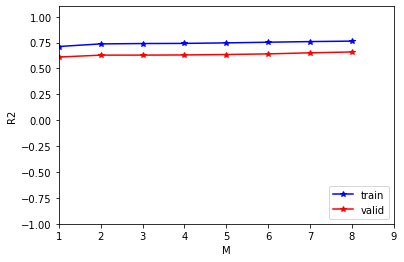

In [65]:
plt.plot(range(1,9),TrainR2[:8],'b-*',label='train')
plt.plot(range(1,9),ValidR2[:8],'r-*',label='valid')
plt.xlabel('M')
plt.ylabel('R2')
plt.ylim(-1,1.1)
plt.xlim(1,9)
plt.legend(loc='lower right')

In [21]:
ValidR2

[0.6104046036154404,
 0.6289346673042764,
 0.6290548648475776,
 0.6307014017819867,
 0.6350297005466263,
 0.6410005682254218,
 0.6511914941166321,
 0.6594783712204204,
 0.6654075435800096]

In [22]:
# finding the max Degree for max R2
M=np.argmax(ValidR2)+1; M

9

In [23]:
# Evaluating regression value over test sample
test['ypred']=lm[M-1].predict(test)
TestR2 = 1-((test.ypred-test.fhv)**2).sum()/((test.fhv-test.fhv.mean())**2).sum()
TestR2

C:\Users\ps336\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.5386270970722191

### Q5 (10pts). Visualize temporal patterns and lag impacts through bar plots
For the best regression above visualize:
- bar plot of hour of the day vs its impact coefficient
- bar plot of day of the week vs its impact coefficient
- bar plot of the lag (0 for immediate arrivals, 1,2,... for lags)

In [ ]:
# Check this online how to do bar plot

In [35]:
datasetL.head()

,date,arrival,fhv,hour,dow,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
0,2018-01-01 09:00:00,15,228,9,0,0,14,5,0,0,0,0,1,0,3
1,2018-01-01 10:00:00,30,253,10,0,0,15,14,5,0,0,0,0,1,0
2,2018-01-01 11:00:00,18,405,11,0,0,30,15,14,5,0,0,0,0,1
3,2018-01-01 12:00:00,14,273,12,0,0,18,30,15,14,5,0,0,0,0
4,2018-01-01 13:00:00,20,254,13,0,0,14,18,30,15,14,5,0,0,0


In [56]:
l = lm__.params.iloc[1:24]
list(l)

[-111.22689027573449,
 -93.71821470022039,
 -91.23341961582003,
 -86.74991648247715,
 -84.93302140164414,
 -86.49874040294844,
 -114.92762036889943,
 -144.34005235661837,
 -107.1785944546653,
 -99.06872596204101,
 -109.51785276048447,
 -105.09301798536808,
 -141.22233990281535,
 -89.69264890785098,
 -93.96773975112487,
 -51.481375558708265,
 -22.630051580844224,
 0.6656943840747545,
 34.272214844960246,
 14.927439977813705,
 90.89706342705426,
 105.12851618440743,
 144.26676209028304]

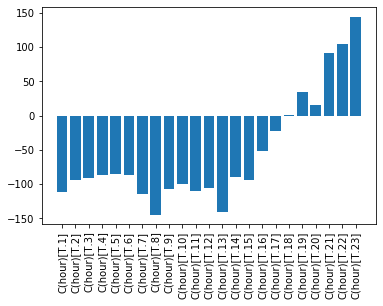

In [57]:
#bar plot of dow  vs its impact coefficient
bars = l.index.tolist()
height = list(l)
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.show()


In [70]:
#bar plot of week  of the day vs its impact coefficient


ll = lm__.params.iloc[24:30]
list(ll)


[-56.543439251897695,
 -48.09315616894704,
 0.776247116959492,
 1.1886749528293103,
 -45.7001621235478,
 19.327079115006853]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

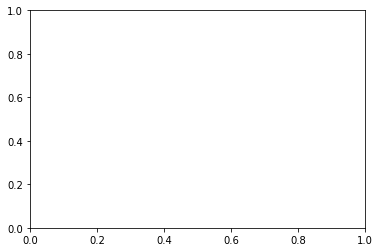

In [71]:
#bar plot of dow  vs its impact coefficient
bars = ll.index.tolist()
height = list(l)
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.show()


## Task 3. Cluster the days of the year based on the relative timeline of their FHV departures from the airport

### Q1 (8pts). From the entire `dataset`, create a dataframe with days as rows, hours as columns and FHV ridership as values (feel free to use pd.pivottable). Normalize by the total daily ridership

In [39]:
#pivot_dataset=df.pivot_table('value_column','row_column','column_column',aggfunc=np.mean)
#dataset=datasetL.pivot_table('value_day','row_day','column_hour')

table = pd.pivot_table(dataset, values='fhv', index=['day'],columns=['hour'], aggfunc=np.sum, fill_value=0)


In [40]:
table.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
0,89,17,2,2,10,12,7,21,116,228,...,341,395,384,575,414,361,353,537,725,679
1,443,40,14,1,6,10,8,121,248,564,...,401,273,375,447,481,471,418,568,610,407
2,409,211,15,3,9,7,22,72,235,361,...,266,304,400,500,384,320,217,256,308,173
3,172,11,3,2,7,10,26,17,20,20,...,69,72,39,40,23,26,24,31,36,41
4,237,101,11,10,2,13,18,57,44,115,...,293,375,353,505,483,544,485,551,459,608


In [41]:

table=table.div(table.sum(axis=1), axis=0)


In [42]:
table.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
0,0.013792,0.002634,0.000310,0.000310,0.001550,0.001860,0.001085,0.003254,0.017976,0.035332,...,0.052844,0.061212,0.059507,0.089106,0.064156,0.055943,0.054703,0.083217,0.112351,0.105222
1,0.059607,0.005382,0.001884,0.000135,0.000807,0.001346,0.001076,0.016281,0.033369,0.075888,...,0.053956,0.036733,0.050457,0.060145,0.064720,0.063375,0.056243,0.076426,0.082078,0.054763
2,0.071604,0.036940,0.002626,0.000525,0.001576,0.001225,0.003852,0.012605,0.041141,0.063200,...,0.046569,0.053221,0.070028,0.087535,0.067227,0.056022,0.037990,0.044818,0.053922,0.030287
3,0.186957,0.011957,0.003261,0.002174,0.007609,0.010870,0.028261,0.018478,0.021739,0.021739,...,0.075000,0.078261,0.042391,0.043478,0.025000,0.028261,0.026087,0.033696,0.039130,0.044565
4,0.037571,0.016011,0.001744,0.001585,0.000317,0.002061,0.002854,0.009036,0.006975,0.018231,...,0.046449,0.059448,0.055961,0.080057,0.076569,0.086240,0.076886,0.087349,0.072765,0.096386


### Q2 (12pts). Try K-means with the differet numbers of clusters k=2..7, reporting average Silhuette score for each. Which k is the "optimal" from Silhuette's standpoint?

In [43]:


range_n_clusters = [2,3,4,5,6,7]
for n_clusters in range_n_clusters:
                tablek=KMeans(random_state=324,n_clusters=n_clusters).fit(table)

In [44]:

for n_clusters in range_n_clusters: #try different numbers of clusters
    tablek= KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = tablek.fit_predict(table)
    #report average Silhouette score
    silhouette_avg = silhouette_score(table, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
    


For n_clusters =2, the average silhouette_score is :0.23155757478167616
For n_clusters =3, the average silhouette_score is :0.1836733364343234
For n_clusters =4, the average silhouette_score is :0.176411965464638
For n_clusters =5, the average silhouette_score is :0.15796742306068604
For n_clusters =6, the average silhouette_score is :0.16336995882169214
For n_clusters =7, the average silhouette_score is :0.15847618631890806


In [45]:
#n cluster 2 is the optimum value 

### Q3 (15pts). Perform K-means with the optimal k from above. Report the number of occurances of each day of the week within each of the clusters. How would you interpret the clusters based on that? Visualize the aggregated hourly timeline over all the days within each cluster.

Please notice that the elements we clusters are days. Each day has a day of the week property - Monday, Tue, … You basically have it as dow column in the dataframe. Let us count how many Mondays, Tuesdays , … you have in each cluster.

Based on the numbers above you may provide your interpretation of the clusters in terms of their weekday decomposition. Its open-ended but you will see a clear pattern once you complete the above.

If you aggregate ridership for each hour of the day over all the days which belong to a given cluster you get the total ridership for this hour of the day for this cluster. When you do it for each hour you get a timeline characterizing the entire cluster (which contains different days with similar timelines, so this aggregated timeline could be thought as a signature representing the cluster). Use appropriate normalization of the timeline by the total ridership within the cluster.

But first of all in order to implement the above it might be useful to create a dictionary of the cluster numbers corresponding to each day of the year, apply it adding a column "cluster" to the dataframe and use pivot table with aggregation function `count` to collect the numbers above. Also use pivot table to collect total riders per hour of the day within each cluster for further visualization.

In [46]:
table.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            355, 356, 357, 358, 359, 360, 361, 362, 363, 364],
           dtype='int64', name='day', length=365)

AttributeError: 'builtin_function_or_method' object has no attribute 'tblekk'

In [47]:
tablekk=KMeans(random_state=324,n_clusters=2)
tablekk=tablek.fit(table)
print(tablekk.labels_)


#km=KMeans(random_state=324,n_clusters=2)
#res=km.fit(data1)
#print(res.labels_)

[0 1 4 4 0 4 0 1 3 6 0 3 2 0 0 1 0 0 6 5 0 1 0 6 0 6 5 0 1 0 6 0 0 4 0 1 6
 0 3 6 5 0 3 6 6 0 0 4 0 0 1 6 0 3 5 0 1 6 6 0 4 5 0 1 6 1 6 6 1 0 1 0 6 6
 6 3 0 1 6 4 0 3 3 0 1 6 6 0 6 5 0 0 1 0 3 6 5 0 1 1 6 6 6 5 0 3 3 6 0 3 5
 0 1 6 0 3 0 4 0 1 6 6 0 3 5 0 1 6 6 5 2 5 0 1 1 2 6 6 5 0 1 1 3 6 6 5 6 0
 1 1 0 3 3 0 1 6 6 6 6 5 0 1 6 6 6 6 4 0 1 3 6 0 6 5 0 2 3 6 0 2 5 6 1 0 5
 1 6 5 0 1 6 6 6 6 5 0 1 3 3 0 6 4 6 2 3 3 3 1 2 0 1 6 1 3 3 4 0 1 1 3 3 6
 3 0 3 1 6 0 5 2 0 1 1 3 0 6 5 0 1 6 6 6 1 4 6 6 1 1 1 3 5 0 1 3 6 6 6 5 0
 1 0 3 6 3 4 0 1 6 5 2 6 5 0 1 6 6 6 6 5 0 1 3 6 0 2 4 0 1 3 6 0 3 5 0 1 6
 6 0 6 5 0 1 6 6 6 6 5 0 1 6 6 0 6 4 0 1 6 3 1 3 4 0 1 6 6 4 5 6 6 1 3 6 0
 6 5 0 1 6 6 6 6 5 0 1 1 6 6 6 5 0 1 3 6 6 6 2 6 5 0 6 1 6 6 6 5]


In [48]:
{k:v for k, v, in zip(table.index,tablekk.labels_)}

{0: 0,
 1: 1,
 2: 4,
 3: 4,
 4: 0,
 5: 4,
 6: 0,
 7: 1,
 8: 3,
 9: 6,
 10: 0,
 11: 3,
 12: 2,
 13: 0,
 14: 0,
 15: 1,
 16: 0,
 17: 0,
 18: 6,
 19: 5,
 20: 0,
 21: 1,
 22: 0,
 23: 6,
 24: 0,
 25: 6,
 26: 5,
 27: 0,
 28: 1,
 29: 0,
 30: 6,
 31: 0,
 32: 0,
 33: 4,
 34: 0,
 35: 1,
 36: 6,
 37: 0,
 38: 3,
 39: 6,
 40: 5,
 41: 0,
 42: 3,
 43: 6,
 44: 6,
 45: 0,
 46: 0,
 47: 4,
 48: 0,
 49: 0,
 50: 1,
 51: 6,
 52: 0,
 53: 3,
 54: 5,
 55: 0,
 56: 1,
 57: 6,
 58: 6,
 59: 0,
 60: 4,
 61: 5,
 62: 0,
 63: 1,
 64: 6,
 65: 1,
 66: 6,
 67: 6,
 68: 1,
 69: 0,
 70: 1,
 71: 0,
 72: 6,
 73: 6,
 74: 6,
 75: 3,
 76: 0,
 77: 1,
 78: 6,
 79: 4,
 80: 0,
 81: 3,
 82: 3,
 83: 0,
 84: 1,
 85: 6,
 86: 6,
 87: 0,
 88: 6,
 89: 5,
 90: 0,
 91: 0,
 92: 1,
 93: 0,
 94: 3,
 95: 6,
 96: 5,
 97: 0,
 98: 1,
 99: 1,
 100: 6,
 101: 6,
 102: 6,
 103: 5,
 104: 0,
 105: 3,
 106: 3,
 107: 6,
 108: 0,
 109: 3,
 110: 5,
 111: 0,
 112: 1,
 113: 6,
 114: 0,
 115: 3,
 116: 0,
 117: 4,
 118: 0,
 119: 1,
 120: 6,
 121: 6,
 122: 0,
 12

In [50]:
datasetL['dow'].value_counts(dropna=False)

0    1263
6    1248
5    1248
4    1248
3    1248
2    1248
1    1248
Name: dow, dtype: int64